# File Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import stat
import math
import geopandas as gpd
import netCDF4
import datetime
import itertools
import shapely 
from shapely.geometry import LineString, shape
import folium
from colormap import rgb2hex
from folium.plugins import FloatImage
from scipy import interpolate
import alphashape
import descartes
import pyproj
import xarray as xr
from random import sample

transformer = \
    pyproj.Transformer.from_crs(pyproj.CRS("EPSG:32760"),pyproj.CRS("EPSG:4326")) 

In [2]:
import os
import rpy2
os.environ['R_HOME'] = '/lib/R'
%load_ext rpy2.ipython

# Load the Super point data

In [3]:
# Load the data
ds_nanumaga = netCDF4.Dataset('SuperPoint_Nanumaga.nc')
ds_nanumea = netCDF4.Dataset('SuperPoint_Nanumea.nc')

var_dict = {}

for ds,atoll in zip([ds_nanumaga,ds_nanumea],['Nanumaga','Nanumea']):
    # Extract the variables
    efth = np.array(ds.variables['efth'])
    time = np.array(ds.variables['time'])
    dirr = np.array(ds.variables['dir'])
    freq = np.array(ds.variables['freq'])
    wdir = np.array(ds.variables['Wdir'])
    wspd = np.array(ds.variables['Wspeed'])

    # Adjust time to be datetime (need to confirm the start time)
    time_start = datetime.datetime(1980,1,1,0,0)
    time = [(time_start+datetime.timedelta(hours=x)) for x in time]
    
    var_dict.update({
        atoll:{
            'efth':efth,
            'time':time,
            'dirr':dirr,
            'freq':freq,
            'wdir':wdir,
            'wspd':wspd
        }
    })
    

# Load the shoreline data

In [4]:
# Load the data using geopandas

proxies = [
    r'TOB',
    r'VL',
    r'WM'
]

atolls = [
    'Nanumea',
    'Nanumaga'
]

locations_dict = {
    'Nanumea':[-5.667723, 176.094928],
    'Nanumaga':[-6.287944, 176.321295]
}

combinations = list(itertools.product(atolls,proxies))

# Define the years the shoreline change datafile is for. This is atoll specific
years_dict = {
    'Nanumea':'1971_2020',
    'Nanumaga':'2003_2020'
}

geopandas_dict = {}

for combination in combinations:
    atoll = combination[0]
    proxy = combination[1]
    year = years_dict[combination[0]]
    geopandas_dict.update({
        (atoll,proxy):gpd.read_file('../D9_Tuvalu_shoreline//Shoreline_Definition_Shp/{}/{}_{}_{}.shp'.format(proxy,atoll,proxy,year))
    })



In [5]:
# converting the geopandas dataframes into a useable pd.dataframe

df_xy_dict = {}

for combination in combinations:
    atoll = combination[0]
    proxy = combination[1]
    year = years_dict[combination[0]]
    
    gdf_test = geopandas_dict[atoll,proxy].copy()

    # Correct some typos
    gdf_test.loc[gdf_test.layer=='Nanumea_WM_2015_','layer'] = 'Nanumea_WM_2015'

    gdf_test['layer'] = gdf_test['layer'].fillna(value=1)
    gdf_test['id'] = gdf_test['id'].fillna(value=1)
    gdf_test.dropna(inplace=True)

    years_list = []
    gdf_right_years_dict = {}

    for layer,group in gdf_test.groupby('layer'):
        if (proxy=='VL')&(atoll!='Nanumaga'):
            year = int(layer.split('_')[1])
        else:
            year = int(layer.split('_')[-1])
        years_list.append(year)

        gdf_right_years_dict.update({
            year:group
        })

    gdf_test = pd.concat(gdf_right_years_dict)
    # gdf_test = gdf_test.rename_axis('year')
    gdf_test.reset_index(drop=False,inplace=True)

    # Convert polygons to linestrings if there are any
    if type(gdf_test.loc[0,'geometry'])==shapely.geometry.Polygon:
        gdf_test['geometry'] = [x.boundary for x in gdf_test.geometry]
        
    # Based on the length of the line segments, calculate the number of segments for this islet
    shape = gdf_test.loc[0,'geometry']
    list_of_line_segments = list(shape.coords)
    total_seg_length = 0
    for seg_1,seg_2 in zip(list_of_line_segments[:-1],list_of_line_segments[1:]):
        total_seg_length+=((seg_1[0]-seg_2[0])**2+(seg_1[1]-seg_2[1])**2)**0.5
    line_segment_length_after_interp = 35
    total_number_of_line_segments = int(np.round(total_seg_length/35))
        
    # Interpolate the linestrings so that they are all of the same length (x)
    x = total_number_of_line_segments #number of points to interpolate
    for i in np.arange(0,len(gdf_test),1):
        gdf_test.loc[i,'geometry'] = \
            shapely.geometry.linestring.LineString(
                [gdf_test.loc[i,'geometry'].interpolate((j/x), normalized=True) for j in range(1, x)]
            )

    dict_of_df_xy = {}

    for idx,row in gdf_test.iterrows():
        linestring = row.geometry
        XY_list = []
        
        if type(linestring)==shapely.geometry.linestring.LineString:
            XY_list = XY_list+[(x,y) for x,y in linestring.coords]
        elif type(linestring)==shapely.geometry.multilinestring.MultiLineString:
            XY_list = XY_list+[(x,y) for x,y in linestring[0].coords]
                
        df_xy = pd.DataFrame(XY_list)
        df_xy.columns = ['lon','lat']
        df_xy['id'] = int(row.id)
        df_xy['year'] = int(row.level_0)
#         print(row.id)
        
        dict_of_df_xy.update({
            idx:df_xy
        })

    df_xy = pd.concat(dict_of_df_xy)

    df_xy = df_xy.reset_index(drop=True)

    df_xy[('lat,lon')] = [transformer.transform(x,y) for x,y in zip(df_xy.lon,df_xy.lat)]
    df_xy['lon'] = [x[1] for x in df_xy[('lat,lon')]]
    df_xy['lat'] = [x[0] for x in df_xy[('lat,lon')]]
    
    gdf_test['level_0'] = gdf_test.level_0.astype(int)
    gdf_test['id'] = gdf_test.id.astype(int)
    gdf_test = gdf_test.rename(columns={'level_0':'year'}).drop('level_1',axis=1)
    
    print(np.unique(df_xy.id))
    print(np.unique(gdf_test.id))
    
    df_xy_dict.update({
        (atoll,proxy):{
            'df_xy':df_xy,
            'gdf_test':gdf_test
        }
    })
    

[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[1 2 3 4 5 6]
[ 1 11]
[ 1 11]
[1]
[1]
[1]
[1]


In [6]:
gdf_test = geopandas_dict[atoll,proxy].copy()

In [7]:
gdf_test

,id,layer,geometry
0,1,Nanumaga_WM_2003,"LINESTRING (424804.160 9303432.237, 424793.511..."
1,1,Nanumaga_WM_2006,"LINESTRING (425283.256 9306121.907, 425313.102..."
2,1,Nanumaga_WM_2008,"LINESTRING (425131.551 9306282.476, 425151.626..."
3,1,Nanumaga_WM_2009,"LINESTRING (424870.654 9306454.737, 424902.057..."
4,1,Nanumaga_WM_2010,"LINESTRING (425369.892 9305874.640, 425370.686..."
5,1,Nanumaga_WM_2011,"LINESTRING (425374.341 9305853.622, 425405.992..."
6,1,Nanumaga_WM_2012,"LINESTRING (425316.298 9306026.362, 425356.911..."
7,1,Nanumaga_WM_2013,"LINESTRING (425420.279 9305734.129, 425417.633..."
8,1,Nanumaga_WM_2014,"LINESTRING (425514.831 9305514.599, 425524.752..."
9,1,Nanumaga_WM_2015,"LINESTRING (425414.359 9305749.971, 425421.895..."


In [8]:
total_number_of_line_segments

205

In [9]:
def redistribute_vertices(geom, distance):
    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return LineString(
            [geom.interpolate(float(n) / num_vert, normalized=True)
             for n in range(num_vert + 1)])
    elif geom.geom_type == 'MultiLineString':
        parts = [redistribute_vertices(part, distance)
                 for part in geom]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))

# Create features from superpoint data

In [10]:
def efth_stat_calc(df,loc):
    '''
        Function for grouping each dataframe into freq bins and calc stats
    '''
    bin_max = np.max(df.efth)
    bin_mean = np.mean(df.efth)

    bin_stats_dict = {
        loc:{
#             'max':bin_max,
            'mean':bin_mean
        }
    }

    return(bin_stats_dict)

In [11]:
waves_per_atoll_year_dict = {}

# Each combination of atoll and proxy combination
for key,item in df_xy_dict.items():
    df_xy = item['df_xy']
    atoll = key[0]

    # Get all the years
    years = np.sort(np.unique(df_xy.year))    
    years_beginning = years[:-1]
    years_end = years[1:]

    # Loop over the years, defining the beginning and the end year
    for year_beginning,year_end in zip(years_beginning,years_end):
            
        time = var_dict[atoll]['time']
        freq = var_dict[atoll]['freq']
        
        beginning = datetime.datetime(year_beginning,1,1,0,0)
        end = datetime.datetime(year_end,12,31,23,59)
        beginning_idx = min(range(len(time)), key=lambda i: abs(time[i]-beginning))
        end_idx = min(range(len(time)), key=lambda i: abs(time[i]-end))

        #################################################
        ## get the wave energy for the right time, place
        #################################################

        xr_atoll = xr.DataArray(data=var_dict[atoll]['efth'],coords=[var_dict[atoll]['dirr'],var_dict[atoll]['freq'],var_dict[atoll]['time']],
                                dims=['dirr','freq','time'])
        xr_atoll = xr_atoll[:,:,beginning_idx:end_idx]
        
        # Bin the frequency bins
        freq_vals = np.unique(freq)
        freq_vals_bin_edges = freq_vals[::int(round(len(freq_vals)/1.99,0))]
        freq_vals_bin_edges = list(freq_vals_bin_edges)+[np.max(freq)]
        
        bin_stats_dict = {}
        
        for lower,upper in zip(freq_vals_bin_edges[:-1],freq_vals_bin_edges[1:]):
            beginning_freq_idx = min(range(len(freq)), key=lambda i: abs(freq[i]-lower))
            end_freq_idx = min(range(len(freq)), key=lambda i: abs(freq[i]-upper))

            xr_freq_atoll = xr_atoll[:,beginning_freq_idx:end_freq_idx,:].copy()
            df_xr_atoll = xr_freq_atoll.to_dataframe('efth').reset_index(drop=False)
        
            # Normalise all values back to 0->360 degress
            df_xr_atoll.dirr= df_xr_atoll.dirr-np.min(df_xr_atoll.dirr)

            # Create bins by quadrants
            df_xr_NE = df_xr_atoll[df_xr_atoll.dirr<=90]
            df_xr_ES = df_xr_atoll[(df_xr_atoll.dirr>90)&(df_xr_atoll.dirr<=180)]
            df_xr_SW = df_xr_atoll[(df_xr_atoll.dirr>180)&(df_xr_atoll.dirr<=270)]
            df_xr_WN = df_xr_atoll[(df_xr_atoll.dirr>270)&(df_xr_atoll.dirr<=360)]

            # Get stats of efth
            NE_bin_stats_dict = efth_stat_calc(df_xr_NE,'NE')
            ES_bin_stats_dict = efth_stat_calc(df_xr_ES,'ES')
            SW_bin_stats_dict = efth_stat_calc(df_xr_SW,'SW')
            WN_bin_stats_dict = efth_stat_calc(df_xr_WN,'WN')
            
            bin_stats_dict.update({
                tuple((lower,upper)):{
                    **NE_bin_stats_dict,
                    **ES_bin_stats_dict,
                    **SW_bin_stats_dict,
                    **WN_bin_stats_dict
                }
            })
        
        waves_per_atoll_year_dict.update({
            tuple((key[0],key[1],year_beginning,year_end)):bin_stats_dict
        })
        print((key[0],key[1],year_beginning,year_end))


('Nanumea', 'TOB', 1971, 1984)
('Nanumea', 'TOB', 1984, 2003)
('Nanumea', 'TOB', 2003, 2005)
('Nanumea', 'TOB', 2005, 2007)
('Nanumea', 'TOB', 2007, 2009)
('Nanumea', 'TOB', 2009, 2010)
('Nanumea', 'TOB', 2010, 2011)
('Nanumea', 'TOB', 2011, 2012)
('Nanumea', 'TOB', 2012, 2013)
('Nanumea', 'TOB', 2013, 2014)
('Nanumea', 'TOB', 2014, 2015)
('Nanumea', 'TOB', 2015, 2016)
('Nanumea', 'TOB', 2016, 2017)
('Nanumea', 'TOB', 2017, 2018)
('Nanumea', 'TOB', 2018, 2019)
('Nanumea', 'TOB', 2019, 2020)
('Nanumea', 'VL', 1971, 1984)
('Nanumea', 'VL', 1984, 2003)
('Nanumea', 'VL', 2003, 2005)
('Nanumea', 'VL', 2005, 2007)
('Nanumea', 'VL', 2007, 2009)
('Nanumea', 'VL', 2009, 2010)
('Nanumea', 'VL', 2010, 2011)
('Nanumea', 'VL', 2011, 2012)
('Nanumea', 'VL', 2012, 2013)
('Nanumea', 'VL', 2013, 2014)
('Nanumea', 'VL', 2014, 2015)
('Nanumea', 'VL', 2015, 2016)
('Nanumea', 'VL', 2016, 2017)
('Nanumea', 'VL', 2017, 2018)
('Nanumea', 'VL', 2018, 2019)
('Nanumea', 'VL', 2019, 2020)
('Nanumea', 'WM', 1971, 

In [12]:
df_xr_atoll

,dirr,freq,time,efth
0,350.0,0.1997,2019-01-01 00:00:00,0.000000
1,350.0,0.1997,2019-01-01 01:00:00,0.000000
2,350.0,0.1997,2019-01-01 02:00:00,0.000000
3,350.0,0.1997,2019-01-01 03:00:00,0.000000
4,350.0,0.1997,2019-01-01 04:00:00,0.000000
...,...,...,...,...
5360503,0.0,0.9096,2019-12-31 18:00:00,0.000000
5360504,0.0,0.9096,2019-12-31 19:00:00,0.000000
5360505,0.0,0.9096,2019-12-31 20:00:00,0.084757
5360506,0.0,0.9096,2019-12-31 21:00:00,0.081204


# Function for plotting shoreline

In [13]:

# def shoreline_map(idx,atoll,proxy):
    
#     gdf_test = geopandas_dict[atoll,proxy].copy()
    
#     # Correct some typos
#     gdf_test.loc[gdf_test.layer=='Nanumea_WM_2015_','layer'] = 'Nanumea_WM_2015'
    
#     # Convert polygons to linestrings if there are any
#     if type(gdf_test.loc[0,'geometry'])==shapely.geometry.Polygon:
#         gdf_test['geometry'] = [x.boundary for x in gdf_test.geometry]
    
#     view = 'Satellite'
#     location = locations_dict[atoll]
#     if view == 'Map':
#         map_osm = folium.Map(location=location,zoom_start=11)
#     elif view == 'Satellite':
#         token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
#         tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)

#         map_osm = folium.Map(location=location, zoom_start=40, tiles=tileurl, attr='Mapbox')

#     years_list = []
#     for layer,group in gdf_test.groupby('layer'):
#         if (proxy=='VL')&(atoll!='Nanumaga'):
#             year = int(layer.split('_')[1])
#         else:
#             year = int(layer.split('_')[-1])
#         years_list.append(year)

#     gdf_test = gdf_test[gdf_test['id']==idx].reset_index(drop=False)

#     len_years = len(years_list)
#     colours_rgb = matplotlib.pyplot.get_cmap('seismic')(np.arange(0,1+1/len_years,1/(len_years-1)))
#     colour_hex_dict = {i:rgb2hex(int(255*colours_rgb[i][0]),int(255*colours_rgb[i][1]),int(255*(colours_rgb[i][2]))) for i in np.arange(0,len_years,1)}

#     colors_hex_points = [colour_hex_dict[x] for x in np.arange(0,len_years,1)]

#     output_list = []

#     i = 0
#     for layer,group in gdf_test.groupby('layer'):
#         folium.Choropleth(
#             group,
#             line_color=colors_hex_points[i]
#         ).add_to(map_osm)

#         output = plt.Line2D([],[],c=colours_rgb[i])
#         output_list.append(output)

#         i+=1

#     legend = plt.legend(output_list,years_list,title='Year',fontsize=10,ncol=3)
#     plt.setp(legend.get_title(),fontsize=12)
#     plt.axis('off')
#     plt.savefig('legend.png')
#     plt.close()
#     url = (
#         "legend.png"
#     )    
#     FloatImage(url, bottom=55, left=55).add_to(map_osm)
#     print(atoll,proxy)
    
#     return(map_osm)

# Visualise the data together

In [14]:
df_xy[df_xy.id==6]

,lon,lat,id,year,"lat,lon"


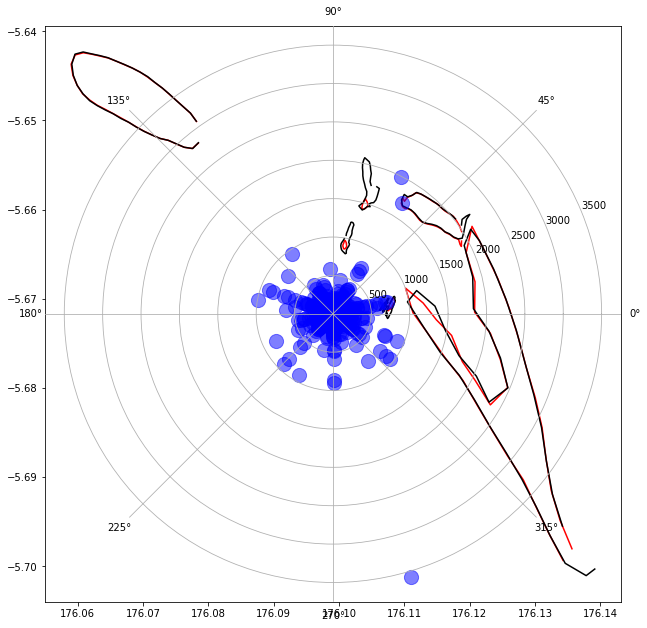

In [74]:

beginning_year = 2019
end_year = 2020

beginning = datetime.datetime(beginning_year,1,1,0,0)
end = datetime.datetime(end_year,12,31,23,59)
atoll = 'Nanumea'
proxy = 'WM'
beginning_idx = min(range(len(time)), key=lambda i: abs(time[i]-beginning))
end_idx = min(range(len(time)), key=lambda i: abs(time[i]-end))

#################################################
## get the wave energy for the right time, place
#################################################

xr_atoll = xr.DataArray(data=var_dict[atoll]['efth'],coords=[var_dict[atoll]['dirr'],var_dict[atoll]['freq'],var_dict[atoll]['time']],
                        dims=['dirr','freq','time'])
xr_atoll = xr_atoll[:,:,beginning_idx:end_idx]
df_xr_atoll = xr_atoll.to_dataframe('efth').reset_index(drop=False)
df_xr_atoll = df_xr_atoll.sample(10000)


# wave_energy_subset = {}

# for time_idx in np.arange(beginning_idx,end_idx,1):
#     test_freq = efth[:,0,time_idx]
    
#     wave_energy_subset.update({
#         time_idx:pd.DataFrame({
#             'dirr':dirr,
#             'freq':test_freq
#         })
#     })

# df_wave_energy = pd.concat(wave_energy_subset)

####################################################
## plotting the atoll
####################################################

df_xy = df_xy_dict[(atoll,proxy)]['df_xy'].copy()

df_xy_start = df_xy[df_xy.year==beginning_year]
df_xy_end = df_xy[df_xy.year==end_year]

############################################################
## Plotting the figure
############################################################

fig = plt.figure(figsize=(10,10))

rect = [0.1,0.1,0.8,0.8]

ax1 = fig.add_axes(rect)

for index,group in df_xy_start.groupby('id'):
    ax1.plot(group.lon,group.lat,c='r')
for index,group in df_xy_end.groupby('id'):
    ax1.plot(group.lon,group.lat,c='k')

ax2 = fig.add_axes(rect,polar=True,frameon=False)

ax2.scatter(df_xr_atoll.dirr,df_xr_atoll.efth,alpha=0.5,s=200,c='b')
    
plt.show()

# Creating Transects

In [16]:

def create_shoreline_df(df_xy):
    # xy = alpha_shape.exterior.coords.xy
    n=2 # length of the shift

    df_shoreline = pd.DataFrame({'x':df_xy.lon[::n],
                                 'x+n':list(df_xy.lon[(n)::n])+[np.nan],
                                 'y':df_xy.lat[::n],
                                 'y+n':list(df_xy.lat[(n)::n])+[np.nan]})

    # Calculate the gradient of the line between the two shoreline points
    df_shoreline['m_shoreline'] = (df_shoreline['y']-df_shoreline['y+n'])/(df_shoreline['x']-df_shoreline['x+n'])
    df_shoreline.dropna(axis=0,inplace=True)
    df_shoreline = df_shoreline[(df_shoreline['x']-df_shoreline['x+n'])!=0]

    # Find the inverse of the gradient (because we are wanting the line that is perpendicular to the shoreline)
    df_shoreline['m_transect'] = -df_shoreline['m_shoreline']**-1

    df_shoreline['x_avg'] = [x/2 for x in (df_shoreline['x']+df_shoreline['x+n'])]
    df_shoreline['y_avg'] = [y/2 for y in (df_shoreline['y']+df_shoreline['y+n'])]

    df_shoreline['c_shoreline'] = df_shoreline['y_avg']-df_shoreline['m_shoreline']*df_shoreline['x_avg']
    df_shoreline['c_transect'] = df_shoreline['y_avg']-df_shoreline['m_transect']*df_shoreline['x_avg']

    # df_shoreline['x_proj'] = df_shoreline['x_avg']+0.01
    # df_shoreline['y_proj'] = df_shoreline['m']*df_shoreline['x_proj']+df_shoreline['c']

    H = 0.001 # length of the line
    delta_y = [abs(H*math.sin(math.atan(m))) for m in df_shoreline['m_transect']]
    delta_x = [abs(H*math.cos(math.atan(m))) for m in df_shoreline['m_transect']]

    # df_shoreline['y_new'] = df_shoreline['y_avg']+delta_y
    # df_shoreline['x_new'] = df_shoreline['x_avg']+delta_x

    df_shoreline['x_new'] = [(x_avg+dx) if y1>y2 else (x_avg-dx) for y1,y2,x_avg,dx in zip(df_shoreline['y'],df_shoreline['y+n'],df_shoreline['x_avg'],delta_x)]
    df_shoreline['y_new'] = [(y_avg+dy) if x1<x2 else (y_avg-dy) for x1,x2,y_avg,dy in zip(df_shoreline['x'],df_shoreline['x+n'],df_shoreline['y_avg'],delta_y)]

    return(df_shoreline)


def calc_shoreline_change(df_shoreline_1,df_shoreline_2,end_year_poly):
    '''
        Function for finding shoreline change between two years
    '''
    ### Now you need to find the distance between the two shorelines using the transects
    shoreline_1_updated_dict = {}

    # loop over each transect
    for idx,row in df_shoreline_1.iterrows():
        
        df_intersection = df_shoreline_2.copy()
        
        df_intersection['x_intersect_location'] = (df_intersection.c_shoreline-row.c_transect)/(row.m_transect-df_intersection.m_shoreline)
        df_intersection['y_intersect_location'] = row['m_transect']*df_intersection['x_intersect_location']+row['c_transect']
        df_intersection['intersect_distance'] = np.sqrt((df_intersection['y_intersect_location']-row['y_avg'])**2+\
        (df_intersection['x_intersect_location']-row['x_avg'])**2)

        # Find which shoreline segments would intersect with the shoreline
        df_intersection = df_intersection[[(x<x_int)&(x_n>x_int)|(x>x_int)&(x_n<x_int)for x,x_int,x_n in zip(df_intersection.x,df_intersection.x_intersect_location,df_intersection['x+n'])]]
        df_intersection = df_intersection[[(y<y_int)&(y_n>y_int)|(y>y_int)&(y_n<y_int) for y,y_int,y_n in zip(df_intersection.y,df_intersection.y_intersect_location,df_intersection['y+n'])]]
        # There may be multiple, so find the closest one (that *should* be the right one)
        
        try:
            df_intersection = df_intersection[(df_intersection['intersect_distance']==np.min(df_intersection['intersect_distance']))]
            intersect_distance = df_intersection.intersect_distance.reset_index(drop=True)[0]
        except:
            intersect_distance = 0
        row['intersect_distance'] = intersect_distance

        shoreline_1_updated_dict.update({
            idx:row
        })

    df_shoreline_1 = pd.DataFrame.from_dict(shoreline_1_updated_dict,orient='index')

    df_shoreline_1['transect_angle'] = \
        np.arctan((df_shoreline_1.y_new-df_shoreline_1.y_avg)/(df_shoreline_1.x_new-df_shoreline_1.x_avg))*180/np.pi

    # Find if there is erosion or accretion
    df_shoreline_1['erosion'] = [shapely.geometry.Point(row.x_avg,row.y_avg).within(end_year_poly) for idx,row in df_shoreline_1.iterrows()]
    
    # If there is erosion, make the value negative
    df_shoreline_1['intersect_distance'] = [dist if eros is False else -dist for dist,eros in zip(df_shoreline_1.intersect_distance,df_shoreline_1.erosion)]
    
    return(df_shoreline_1)


def calc_shoreline_slope_change(df_shoreline_1,df_shoreline_2):
    '''
        Find the rate of change in the shoreline direction
    '''
    
    df_shoreline_1 = pd.concat([df_shoreline_1,df_shoreline_1])
    df_shoreline_2 = pd.concat([df_shoreline_2,df_shoreline_2])

    df_shoreline_1 = df_shoreline_1.reset_index(drop=True)
    df_shoreline_2 = df_shoreline_2.reset_index(drop=True)

    df_shoreline_1_dict = {}

    for (idx_1,row_1),(idx_2,row_2),(idx_3,row_3) in zip(
        df_shoreline_1[2:].iterrows(),
        df_shoreline_1[1:-1].iterrows(),
        df_shoreline_1[:-2].iterrows()):
        
        row_2['avg_slope_change'] = np.mean([
            (360*np.arctan((row_1.m_shoreline-row_2.m_shoreline)/(1+row_1.m_shoreline*row_2.m_shoreline))/np.pi),
            (360*np.arctan((row_2.m_shoreline-row_3.m_shoreline)/(1+row_2.m_shoreline*row_3.m_shoreline))/np.pi)
        ])

        df_shoreline_1_dict.update({
            idx_2:row_2
        })

    # only look at points where there is a significant change
    df_shoreline_1 = pd.DataFrame.from_dict(df_shoreline_1_dict,orient='index')
    
    # Drop the duplicates
    df_shoreline_1 = df_shoreline_1.drop_duplicates()
    df_shoreline_1.reset_index(drop=True,inplace=True)
    
    #### Now also add in the angle (degrees) that the shoreline is facing
    # Quadrant 1
    df_shoreline_1.loc[(df_shoreline_1.x_new>df_shoreline_1.x_avg)&(df_shoreline_1.y_new>df_shoreline_1.y_avg),'shoreline_direction']=\
        [180*math.atan(np.abs(x_new-x_avg)/np.abs(y_new-y_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new>x_avg)&(y_new>y_avg)]

    # Quadrant 2
    df_shoreline_1.loc[(df_shoreline_1.x_new>df_shoreline_1.x_avg)&(df_shoreline_1.y_new<df_shoreline_1.y_avg),'shoreline_direction']=\
        [90+180*math.atan(np.abs(y_new-y_avg)/np.abs(x_new-x_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new>x_avg)&(y_new<y_avg)]

    # Quadrant 3
    df_shoreline_1.loc[(df_shoreline_1.x_new<df_shoreline_1.x_avg)&(df_shoreline_1.y_new<df_shoreline_1.y_avg),'shoreline_direction']=\
        [180+180*math.atan(np.abs(x_new-x_avg)/np.abs(y_new-y_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new<x_avg)&(y_new<y_avg)]

    # Quadrant 4
    df_shoreline_1.loc[(df_shoreline_1.x_new<df_shoreline_1.x_avg)&(df_shoreline_1.y_new>df_shoreline_1.y_avg),'shoreline_direction']=\
        [270+180*math.atan(np.abs(y_new-y_avg)/np.abs(x_new-x_avg))/np.pi for y_new,y_avg,x_new,x_avg in zip(
                df_shoreline_1.y_new,
                df_shoreline_1.y_avg,
                df_shoreline_1.x_new,
                df_shoreline_1.x_avg
                ) if (x_new<x_avg)&(y_new>y_avg)]

    return(df_shoreline_1)

In [17]:
# For each year, proxy and islet combination, find the shoreline change
shorelines_dict = {}

# Each combination of atoll and proxy combination
for key,item in df_xy_dict.items():
    df_xy = item['df_xy']
    gdf_xy = item['gdf_test']
    
    # Now get all the ids for this atoll
    ids = np.unique(df_xy.id)
    
    for ID in ids:
        df_xy_islet = df_xy[df_xy.id==ID]
        gdf_xy_islet = gdf_xy[gdf_xy.id==ID]
            
        # Get all the years
        years = np.sort(np.unique(df_xy_islet.year))
        years_beginning = years[:-1]
        years_end = years[1:]
        
        # Loop over the years, defining the beginning and the end year
        for year_beginning,year_end in zip(years_beginning,years_end):
            
            df_xy_islet_beginning = df_xy_islet[(df_xy_islet.year==year_beginning)]
            df_xy_islet_end = df_xy_islet[(df_xy_islet.year==year_end)]
            
            end_year_linestring = gdf_xy_islet[(gdf_xy_islet.year==year_end)].reset_index().loc[0,'geometry']
            end_year_poly = shapely.ops.transform(lambda x, y: (y, x),
                      shapely.geometry.Polygon([transformer.transform(x,y) for x,y in end_year_linestring.coords])
                     )
            
            
            df_shoreline_1 = create_shoreline_df(df_xy_islet_beginning).reset_index(drop=True)
            df_shoreline_2 = create_shoreline_df(df_xy_islet_end).reset_index(drop=True)

            df_shoreline_1 = calc_shoreline_change(df_shoreline_1,df_shoreline_2,end_year_poly)

            df_shoreline_1 = calc_shoreline_slope_change(df_shoreline_1,df_shoreline_2)
            
            shorelines_dict.update({
                (key[0],key[1],ID,year_beginning,year_end):{
                    'shoreline_1':df_shoreline_1,
                    'shoreline_2':df_shoreline_2
                }
            })
            print((key[0],key[1],ID,year_beginning,year_end))
            

('Nanumea', 'TOB', 1, 1971, 1984)
('Nanumea', 'TOB', 1, 1984, 2003)
('Nanumea', 'TOB', 1, 2003, 2005)
('Nanumea', 'TOB', 1, 2005, 2007)
('Nanumea', 'TOB', 1, 2007, 2009)
('Nanumea', 'TOB', 1, 2009, 2010)
('Nanumea', 'TOB', 1, 2010, 2011)
('Nanumea', 'TOB', 1, 2011, 2012)
('Nanumea', 'TOB', 1, 2012, 2013)
('Nanumea', 'TOB', 1, 2013, 2014)
('Nanumea', 'TOB', 1, 2014, 2015)
('Nanumea', 'TOB', 1, 2015, 2016)
('Nanumea', 'TOB', 1, 2016, 2017)
('Nanumea', 'TOB', 1, 2017, 2018)
('Nanumea', 'TOB', 1, 2018, 2019)
('Nanumea', 'TOB', 1, 2019, 2020)
('Nanumea', 'TOB', 2, 1971, 1984)
('Nanumea', 'TOB', 2, 1984, 2003)
('Nanumea', 'TOB', 2, 2003, 2005)
('Nanumea', 'TOB', 2, 2005, 2007)
('Nanumea', 'TOB', 2, 2007, 2009)
('Nanumea', 'TOB', 2, 2009, 2010)
('Nanumea', 'TOB', 2, 2010, 2011)
('Nanumea', 'TOB', 2, 2011, 2012)
('Nanumea', 'TOB', 2, 2012, 2013)
('Nanumea', 'TOB', 2, 2013, 2014)
('Nanumea', 'TOB', 2, 2014, 2015)
('Nanumea', 'TOB', 2, 2015, 2016)
('Nanumea', 'TOB', 2, 2016, 2017)
('Nanumea', 'T

('Nanumea', 'WM', 4, 2016, 2017)
('Nanumea', 'WM', 4, 2017, 2018)
('Nanumea', 'WM', 4, 2018, 2019)
('Nanumea', 'WM', 4, 2019, 2020)
('Nanumea', 'WM', 5, 1971, 1984)
('Nanumea', 'WM', 5, 1984, 2003)
('Nanumea', 'WM', 5, 2003, 2005)
('Nanumea', 'WM', 5, 2005, 2007)
('Nanumea', 'WM', 5, 2007, 2009)
('Nanumea', 'WM', 5, 2009, 2010)
('Nanumea', 'WM', 5, 2010, 2011)
('Nanumea', 'WM', 5, 2011, 2012)
('Nanumea', 'WM', 5, 2012, 2014)
('Nanumea', 'WM', 5, 2014, 2015)
('Nanumea', 'WM', 5, 2015, 2016)
('Nanumea', 'WM', 5, 2016, 2017)
('Nanumea', 'WM', 5, 2017, 2018)
('Nanumea', 'WM', 5, 2018, 2019)
('Nanumea', 'WM', 5, 2019, 2020)
('Nanumea', 'WM', 6, 1971, 1984)
('Nanumea', 'WM', 6, 1984, 2003)
('Nanumea', 'WM', 6, 2003, 2005)
('Nanumea', 'WM', 6, 2005, 2007)
('Nanumea', 'WM', 6, 2007, 2009)
('Nanumea', 'WM', 6, 2009, 2010)
('Nanumea', 'WM', 6, 2010, 2011)
('Nanumea', 'WM', 6, 2011, 2012)
('Nanumea', 'WM', 6, 2012, 2014)
('Nanumea', 'WM', 6, 2014, 2015)
('Nanumea', 'WM', 6, 2015, 2016)
('Nanumea'

# Plotting the Result

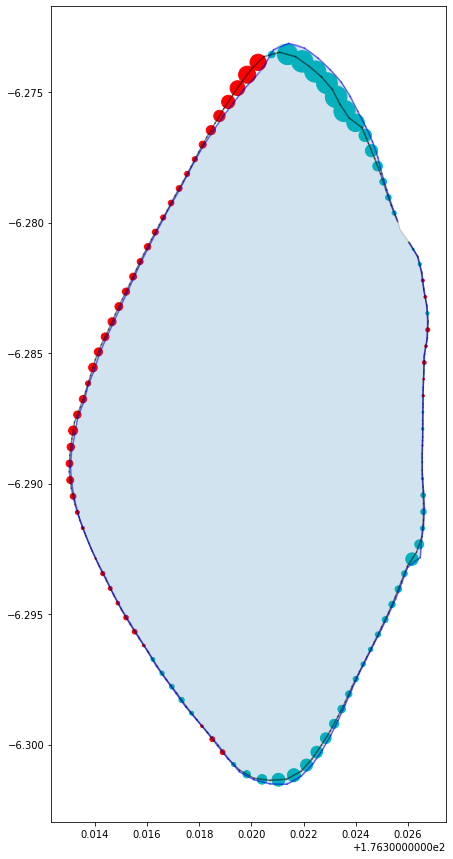

In [18]:
fig = plt.figure(figsize=(15,15))

ax = plt.subplot2grid((1,1),(0,0))

[ax.plot([x,x_n],[y,y_n],alpha=0.5,c='k') for x,x_n,y,y_n in zip(
    df_shoreline_1['x'],
    df_shoreline_1['x+n'],
    df_shoreline_1['y'],
    df_shoreline_1['y+n']
)]

[ax.plot([x,x_n],[y,y_n],alpha=0.5,c='b') for x,x_n,y,y_n in zip(
    df_shoreline_2['x'],
    df_shoreline_2['x+n'],
    df_shoreline_2['y'],
    df_shoreline_2['y+n']
)]

df_shoreline_erosion = df_shoreline_1[df_shoreline_1.erosion==True]
ax.scatter(df_shoreline_erosion['x_avg'],df_shoreline_erosion['y_avg'],s=[-x*1000000 for x in df_shoreline_erosion['intersect_distance']],
            alpha=1,c='c',zorder=-1000)

df_shoreline_acretion = df_shoreline_1[df_shoreline_1.erosion==False]
ax.scatter(df_shoreline_acretion['x_avg'],df_shoreline_acretion['y_avg'],s=1000000*df_shoreline_acretion['intersect_distance'],
            alpha=1,c='r',zorder=-1000)

# [ax.plot([x_avg,x_proj],[y_avg,y_proj],alpha=0.5,c='r') for x_avg,x_proj,y_avg,y_proj in zip(
#     df_shoreline_1['x_avg'],
#     df_shoreline_1['x_new'],
#     df_shoreline_1['y_avg'],
#     df_shoreline_1['y_new']
# )]

# ax.set_xlim(177.5,177.75)
# ax.set_ylim(-6.305,-6.27)
ax.set_aspect('equal', adjustable='box')

ax.add_patch(descartes.PolygonPatch(end_year_poly,alpha=0.2))

# plt.plot(x_test,y_test,c='b')

plt.show()

/tmp/ipykernel_634/1286431431.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_shoreline_1_concave['avg_slope_change'] = np.abs(df_shoreline_1_concave.avg_slope_change)


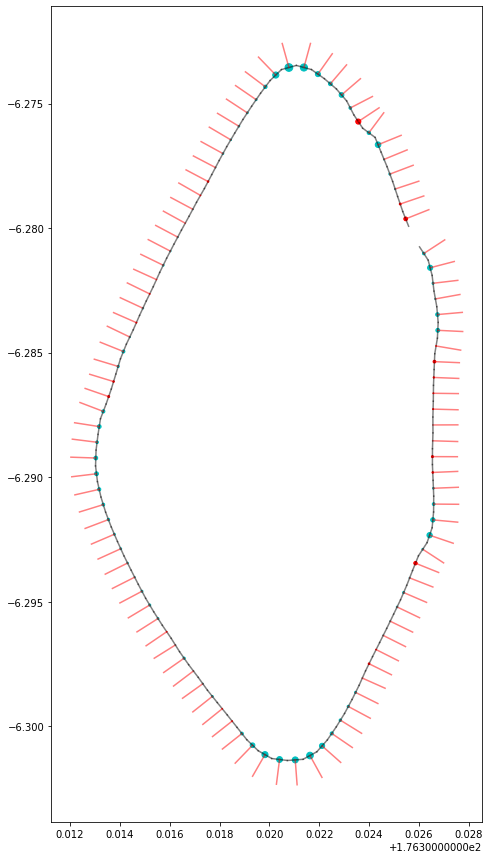

In [19]:
fig = plt.figure(figsize=(15,15))

ax = plt.subplot2grid((1,1),(0,0))

[ax.plot([x,x_n],[y,y_n],alpha=0.5,c='k') for x,x_n,y,y_n in zip(
    df_shoreline_1['x'],
    df_shoreline_1['x+n'],
    df_shoreline_1['y'],
    df_shoreline_1['y+n']
)]

df_shoreline_1_concave = df_shoreline_1[df_shoreline_1.avg_slope_change<0]
df_shoreline_1_concave['avg_slope_change'] = np.abs(df_shoreline_1_concave.avg_slope_change)
df_shoreline_1_convex = df_shoreline_1[df_shoreline_1.avg_slope_change>0]

ax.scatter(df_shoreline_1_concave['x_avg'],df_shoreline_1_concave['y_avg'],s=1*df_shoreline_1_concave['avg_slope_change'],
            alpha=1,c='c',zorder=-1000)
ax.scatter(df_shoreline_1_convex['x_avg'],df_shoreline_1_convex['y_avg'],s=1*df_shoreline_1_convex['avg_slope_change'],
            alpha=1,c='r',zorder=-1000)

[ax.plot([x_avg,x_proj],[y_avg,y_proj],alpha=0.5,c='r') for x_avg,x_proj,y_avg,y_proj in zip(
    df_shoreline_1['x_avg'],
    df_shoreline_1['x_new'],
    df_shoreline_1['y_avg'],
    df_shoreline_1['y_new']
)]

# ax.set_xlim(177.5,177.75)
# ax.set_ylim(-6.305,-6.27)
ax.set_aspect('equal', adjustable='box')

# ax.add_patch(descartes.PolygonPatch(alpha_shape,alpha=0.2))

# plt.plot(x_test,y_test,c='b')

plt.show()

# Determine if you are in the shoreline and the lagoon

In [20]:
# atoll = 'Nanumea'
# proxy = 'TOB'

# shoreline_poly_list = []

# ids = id_dict[(atoll,proxy)]

# for idx in ids:
#     df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, 1971, 1984)]['shoreline_1'].copy()
#     df_xy_1 = shorelines_dict[(atoll, proxy, idx, 1971, 1984)]['shoreline_1'].copy()
#     shoreline_1_poly = shapely.ops.transform(lambda x, y: (y, x),
#                               shapely.geometry.Polygon([(y,x) for x,y in zip(df_shoreline_1.x,df_shoreline_1.y)])
#                                             )
    
#     shoreline_poly_list.append(
#         shoreline_1_poly
#     )


In [21]:
def calc_sheltering(lats,lons,label,row):
    sheltered = []
    for lat,lon in zip(lats,lons):

        sheltered_per_islet = []
        for shoreline_1_poly in shoreline_poly_list:

            sheltered_per_islet.append(
                LineString([shapely.geometry.Point(row.x_new,row.y_new),
                   shapely.geometry.Point(lon,lat)]).intersects(shoreline_1_poly)
            )
        sheltered.append(any(sheltered_per_islet))
    row[label] = sum(sheltered)>sum([not x for x in sheltered])

    return(row)

delta_lons = [np.sqrt(1/(1+np.tan(theta)**2)) for theta in np.arange(0,360,15)*math.pi/360]
delta_lats = [np.sqrt(np.tan(theta)**2/(1+np.tan(theta)**2)) for theta in np.arange(0,360,15)*math.pi/360]

combinations = []
for key in list(shorelines_dict.keys()):
    combinations.append((key[0],key[1],key[3],key[4]))
    
combinations = [t for t in (set(combinations))]

for key in combinations:
    print(key)
    atoll = key[0]
    proxy = key[1]
    beginning_year = key[2]
    end_year = key[3]

    shoreline_poly_list = []

    ids = []
    for n in np.arange(0,20,1):
        try:
            shorelines_dict[(atoll,proxy,n,beginning_year,end_year)]
            ids.append(n)
        except:
            continue

    for idx in ids:
        df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1'].copy()
        df_xy_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1'].copy()
        shoreline_1_poly = shapely.ops.transform(lambda x, y: (y, x),
                                  shapely.geometry.Polygon([(y,x) for x,y in zip(df_shoreline_1.x,df_shoreline_1.y)])
                                                )

        shoreline_poly_list.append(
            shoreline_1_poly
        )

    i=0
    for idx in ids:
        df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1'].copy()

        shoreline_1_dict = {}

        for index,row in df_shoreline_1.iterrows():

            NE_lons = [row.x_avg+delta_lon for delta_lon in delta_lons]
            NE_lats = [row.y_avg+delta_lat for delta_lat in delta_lats]

            ES_lons = [row.x_avg+delta_lon for delta_lon in delta_lons]
            ES_lats = [row.y_avg-delta_lat for delta_lat in delta_lats]

            SW_lons = [row.x_avg-delta_lon for delta_lon in delta_lons]
            SW_lats = [row.y_avg-delta_lat for delta_lat in delta_lats]

            WN_lons = [row.x_avg-delta_lon for delta_lon in delta_lons]
            WN_lats = [row.y_avg+delta_lat for delta_lat in delta_lats]


            row = calc_sheltering(NE_lats,NE_lons,'NE_sheltered',row)
            row = calc_sheltering(ES_lats,ES_lons,'ES_sheltered',row)
            row = calc_sheltering(SW_lats,SW_lons,'SW_sheltered',row)
            row = calc_sheltering(WN_lats,WN_lons,'WN_sheltered',row)


            shoreline_1_dict.update({
                index:row
            })

        df_shoreline_1 = pd.DataFrame.from_dict(shoreline_1_dict,orient='index')

        shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)].update({
            'shoreline_1':df_shoreline_1
        })            
            

('Nanumea', 'WM', 2005, 2007)
('Nanumaga', 'VL', 2006, 2008)
('Nanumea', 'WM', 1971, 1984)
('Nanumaga', 'WM', 2003, 2006)
('Nanumea', 'VL', 2014, 2015)
('Nanumea', 'VL', 2007, 2009)
('Nanumaga', 'WM', 2009, 2010)
('Nanumea', 'TOB', 2010, 2011)
('Nanumea', 'VL', 2010, 2011)
('Nanumea', 'VL', 2003, 2005)
('Nanumaga', 'TOB', 2012, 2013)
('Nanumaga', 'TOB', 2017, 2018)
('Nanumea', 'TOB', 2016, 2017)
('Nanumea', 'TOB', 2011, 2012)
('Nanumea', 'VL', 2016, 2017)
('Nanumea', 'WM', 2012, 2014)
('Nanumaga', 'TOB', 2013, 2014)
('Nanumea', 'TOB', 2012, 2013)
('Nanumaga', 'TOB', 2009, 2010)
('Nanumea', 'TOB', 1984, 2003)
('Nanumea', 'VL', 1984, 2003)
('Nanumaga', 'WM', 2016, 2017)
('Nanumea', 'TOB', 2017, 2018)
('Nanumea', 'TOB', 2005, 2007)
('Nanumaga', 'TOB', 2003, 2006)
('Nanumaga', 'WM', 2012, 2013)
('Nanumea', 'VL', 2005, 2007)
('Nanumaga', 'TOB', 2014, 2015)
('Nanumea', 'TOB', 2018, 2019)
('Nanumea', 'VL', 2018, 2019)
('Nanumaga', 'WM', 2013, 2014)
('Nanumea', 'TOB', 2014, 2015)
('Nanumaga', 

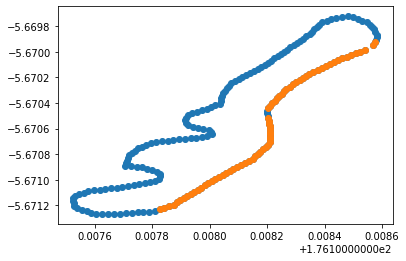

In [22]:
plt.scatter(df_shoreline_1.x,df_shoreline_1.y)

df_shoreline_1_NE_sheltered = df_shoreline_1[df_shoreline_1.WN_sheltered==True]

plt.scatter(df_shoreline_1_NE_sheltered.x,df_shoreline_1_NE_sheltered.y)

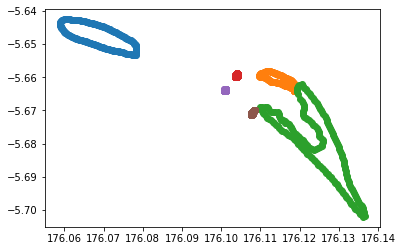

In [23]:
for idx in ids:
    df_shoreline_1 = shorelines_dict[(atoll, proxy, idx, beginning_year, end_year)]['shoreline_1']
    
    plt.scatter(df_shoreline_1.x,df_shoreline_1.y)
    
    

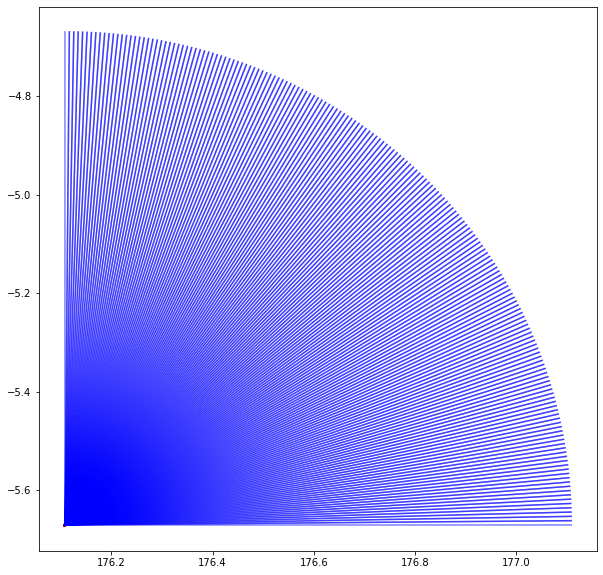

In [24]:
fig = plt.figure(figsize=(10,10))

ax = plt.subplot2grid((1,1),(0,0))

delta_lons = [np.sqrt(1/(1+np.tan(theta)**2)) for theta in np.arange(0,360,1)*math.pi/360]
delta_lats = [np.sqrt(np.tan(theta)**2/(1+np.tan(theta)**2)) for theta in np.arange(0,360,1)*math.pi/360]

lons = [row.x_avg+delta_lon for delta_lon in delta_lons]
lats = [row.y_avg+delta_lat for delta_lat in delta_lats]

[ax.plot([x_avg,x_proj],[y_avg,y_proj],alpha=0.5,c='r') for x_avg,x_proj,y_avg,y_proj in zip(
    df_shoreline_1['x_avg'],
    df_shoreline_1['x_new'],
    df_shoreline_1['y_avg'],
    df_shoreline_1['y_new']
)]

[
    ax.plot([df_shoreline_1.loc[0,'x_avg'],lon],
         [df_shoreline_1.loc[0,'y_avg'],lat],
         alpha=0.5,c='b') for lon,lat in zip(lons,lats)
]

plt.show()

# Look at the correlation between these variables and the change in shoreline

In [25]:
df_combined_shoreline_change = pd.concat({keys:dicts['shoreline_1'] for keys,dicts in shorelines_dict.items()})
df_combined_shoreline_change = \
    df_combined_shoreline_change.reset_index(drop=False).rename(columns={
        'level_0':'atoll',
        'level_1':'proxy',
        'level_2':'islet_id',
        'level_3':'beginning_year',
        'level_4':'end_year'
    }).drop('level_5',axis=1)

In [26]:
# Round the shoreline direction to the nearest 45 degrees
df_combined_shoreline_change['shoreline_direction'] = (df_combined_shoreline_change.shoreline_direction/45).round()*45
df_combined_shoreline_change['avg_slope_change'] = (df_combined_shoreline_change.avg_slope_change/45).round()*45


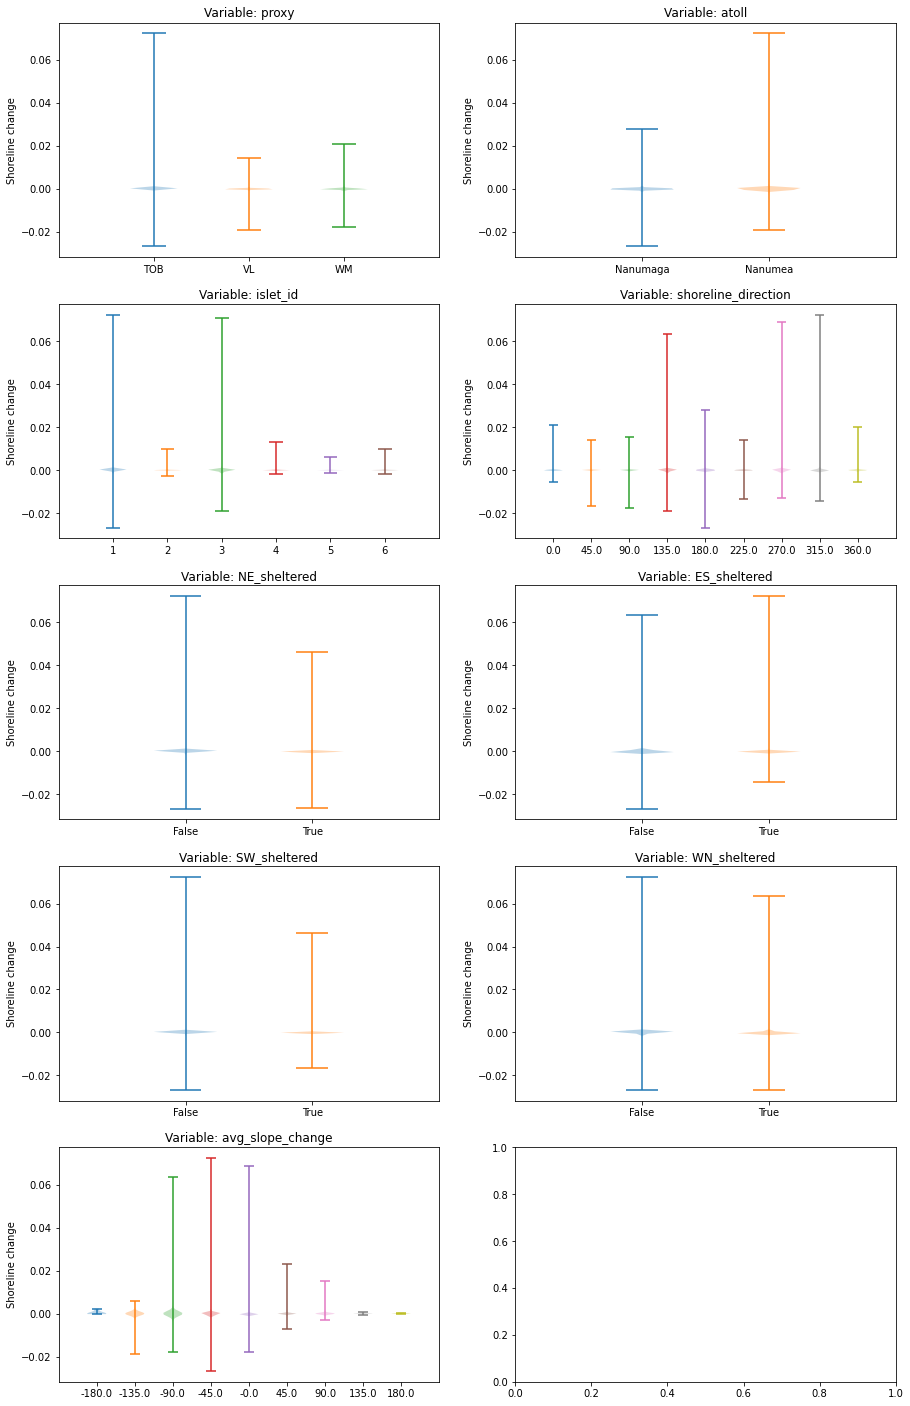

In [27]:

def create_boxplot(var,ax):
    x=0
    xticks_list = []
    for key,group in df_combined_shoreline_change.groupby(var):
        ax.violinplot(dataset=group.intersect_distance,positions=[x])
        x+=1
        xticks_list.append(key)

#     ax.set_xticklabels(xticks_list)
    ax.set(xlim=(-1,x),xticks=np.arange(0,x,1))
    ax.set_xticklabels(xticks_list)
    ax.set_ylabel('Shoreline change')
    ax.set_title('Variable: {}'.format(var))
    
    return(ax)

fig = plt.figure(figsize=(15,25))

ax1 = plt.subplot2grid((5,2),(0,0))
ax2 = plt.subplot2grid((5,2),(0,1))
ax3 = plt.subplot2grid((5,2),(1,0))
ax4 = plt.subplot2grid((5,2),(1,1))
ax5 = plt.subplot2grid((5,2),(2,0))
ax6 = plt.subplot2grid((5,2),(2,1))
ax7 = plt.subplot2grid((5,2),(3,0))
ax8 = plt.subplot2grid((5,2),(3,1))
ax9 = plt.subplot2grid((5,2),(4,0))
ax10 = plt.subplot2grid((5,2),(4,1))

ax1 = create_boxplot('proxy',ax1)
ax2 = create_boxplot('atoll',ax2)
ax3 = create_boxplot('islet_id',ax3)
ax4 = create_boxplot('shoreline_direction',ax4)
ax5 = create_boxplot('NE_sheltered',ax5)
ax6 = create_boxplot('ES_sheltered',ax6)
ax7 = create_boxplot('SW_sheltered',ax7)
ax8 = create_boxplot('WN_sheltered',ax8)
ax9 = create_boxplot('avg_slope_change',ax9)



In [28]:
key_vars = ['proxy','atoll','islet_id','shoreline_direction','NE_sheltered','ES_sheltered','SW_sheltered','WN_sheltered','avg_slope_change','intersect_distance']

corr = df_combined_shoreline_change[key_vars].corr()

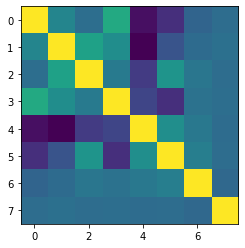

In [29]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.imshow(corr)

In [69]:
corr.intersect_distance

(0.033, 0.1997, ES, mean)    0.006517
(0.033, 0.1997, NE, mean)   -0.007087
(0.033, 0.1997, SW, mean)    0.005084
(0.033, 0.1997, WN, mean)   -0.005285
(0.1997, 1.0, ES, mean)      0.008925
(0.1997, 1.0, NE, mean)     -0.011248
(0.1997, 1.0, SW, mean)      0.005104
(0.1997, 1.0, WN, mean)     -0.010993
islet_id                    -0.001664
shoreline_direction          0.016372
NE_sheltered                -0.001686
ES_sheltered                 0.005190
SW_sheltered                -0.007847
WN_sheltered                -0.005270
avg_slope_change            -0.028385
intersect_distance           1.000000
Name: intersect_distance, dtype: float64

In [31]:
df_combined_shoreline_change

,atoll,proxy,islet_id,beginning_year,end_year,x,x+n,y,y+n,m_shoreline,...,y_new,intersect_distance,transect_angle,erosion,avg_slope_change,shoreline_direction,NE_sheltered,ES_sheltered,SW_sheltered,WN_sheltered
0,Nanumea,TOB,1,1971,1984,176.136769,176.136360,-5.701758,-5.702001,0.594855,...,-5.702739,0.000467,-59.253481,False,-135.0,135.0,False,False,False,False
1,Nanumea,TOB,1,1971,1984,176.136360,176.135914,-5.702001,-5.701554,-1.003020,...,-5.702484,0.000384,44.913625,False,-90.0,225.0,True,False,False,True
2,Nanumea,TOB,1,1971,1984,176.135914,176.135474,-5.701554,-5.701100,-1.032140,...,-5.702023,0.000144,44.093886,False,-0.0,225.0,True,False,False,True
3,Nanumea,TOB,1,1971,1984,176.135474,176.135048,-5.701100,-5.700633,-1.095341,...,-5.701541,0.000099,42.394761,False,-0.0,225.0,True,False,False,True
4,Nanumea,TOB,1,1971,1984,176.135048,176.134631,-5.700633,-5.700158,-1.142439,...,-5.701054,0.000070,41.196312,False,-0.0,225.0,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29710,Nanumaga,WM,1,2019,2020,176.324724,176.324950,-6.277536,-6.278131,-2.637033,...,-6.277479,-0.000093,20.767432,True,-0.0,90.0,False,False,True,False
29711,Nanumaga,WM,1,2019,2020,176.324950,176.325149,-6.278131,-6.278734,-3.020467,...,-6.278118,-0.000045,18.318397,True,-0.0,90.0,False,False,True,True
29712,Nanumaga,WM,1,2019,2020,176.325149,176.325355,-6.278734,-6.279336,-2.925147,...,-6.278711,-0.000032,18.873666,True,0.0,90.0,False,False,True,True
29713,Nanumaga,WM,1,2019,2020,176.325355,176.325590,-6.279336,-6.279927,-2.515648,...,-6.279262,-0.000018,21.678411,True,0.0,90.0,False,False,True,True


(array([8.0000e+00, 2.3000e+01, 2.9601e+04, 5.4000e+01, 1.5000e+01,
        7.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 5.0000e+00]),
 array([-0.02675858, -0.01684646, -0.00693434,  0.00297777,  0.01288989,
         0.022802  ,  0.03271412,  0.04262624,  0.05253835,  0.06245047,
         0.07236259]),
 <BarContainer object of 10 artists>)

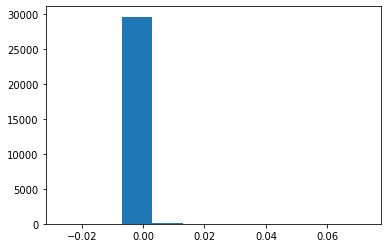

In [32]:
plt.hist(df_combined_shoreline_change.intersect_distance)

In [33]:
%%R -i df_combined_shoreline_change -o intersect_distance_summary

intersect_distance_summary = summary(df_combined_shoreline_change$intersect_distance)
intersect_distance_summary


      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-2.676e-02 -3.015e-05  0.000e+00  2.931e-05  3.526e-05  7.236e-02 


In [34]:
intersect_distance_summary

array([-2.67585767e-02, -3.01506133e-05,  0.00000000e+00,  2.93112069e-05,
        3.52630409e-05,  7.23625859e-02])

In [35]:
q1 = intersect_distance_summary[1]
q3 = intersect_distance_summary[3]

In [36]:
df_combined_shoreline_change_extremes = df_combined_shoreline_change[(df_combined_shoreline_change.intersect_distance<-0.001)|(df_combined_shoreline_change.intersect_distance>0.001)]

(array([  8.,  23., 156.,  54.,  15.,   7.,   0.,   1.,   1.,   5.]),
 array([-0.02675858, -0.01684646, -0.00693434,  0.00297777,  0.01288989,
         0.022802  ,  0.03271412,  0.04262624,  0.05253835,  0.06245047,
         0.07236259]),
 <BarContainer object of 10 artists>)

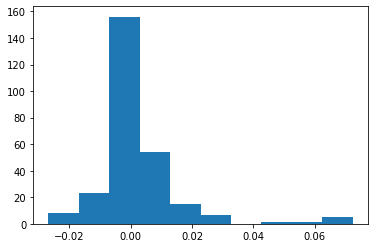

In [37]:
plt.hist(df_combined_shoreline_change_extremes.intersect_distance)

In [38]:
print(df_combined_shoreline_change_extremes[key_vars].corr().intersect_distance)

islet_id               0.019102
shoreline_direction    0.208852
NE_sheltered          -0.015225
ES_sheltered           0.099664
SW_sheltered          -0.135553
WN_sheltered          -0.107807
avg_slope_change      -0.096233
intersect_distance     1.000000
Name: intersect_distance, dtype: float64


In [39]:
key_vars = ['proxy','shoreline_direction','NE_sheltered','ES_sheltered','SW_sheltered','WN_sheltered','avg_slope_change','intersect_distance']
corr_dict = {}
for key,group in df_combined_shoreline_change_extremes.groupby(['atoll','islet_id']):
    corr_dict.update({
        key:group[key_vars].corr().intersect_distance.to_dict()
    })

In [40]:
pd.DataFrame.from_dict(corr_dict,orient='index')

shoreline_direction  NE_sheltered  ES_sheltered  SW_sheltered  \
Nanumaga 1             0.080899      0.080042     -0.026217     -0.129576   
Nanumea  1             0.290000     -0.199770      0.047848     -0.465379   
         2             0.099199      0.068520      0.080123     -0.021141   
         3             0.597152      0.057284      0.640579     -0.023228   
         4             0.337367      0.122809           NaN     -0.245485   
         5            -0.099463      0.059862      0.079972      0.066081   
         6             0.343541     -0.215801      0.326098     -0.177048   

            WN_sheltered  avg_slope_change  intersect_distance  
Nanumaga 1     -0.308241         -0.279581                 1.0  
Nanumea  1     -0.251495         -0.116382                 1.0  
         2      0.406769         -0.178783                 1.0  
         3     -0.171042         -0.120900                 1.0  
         4     -0.106991          0.213124                 1.0  
         5     -0.137632          0.137290                 1.0  
         6      0.019587          0.041163                 1.0

# Looking at the change in shoreline on a per year basis

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/tmp/ipykernel_634/1022707457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

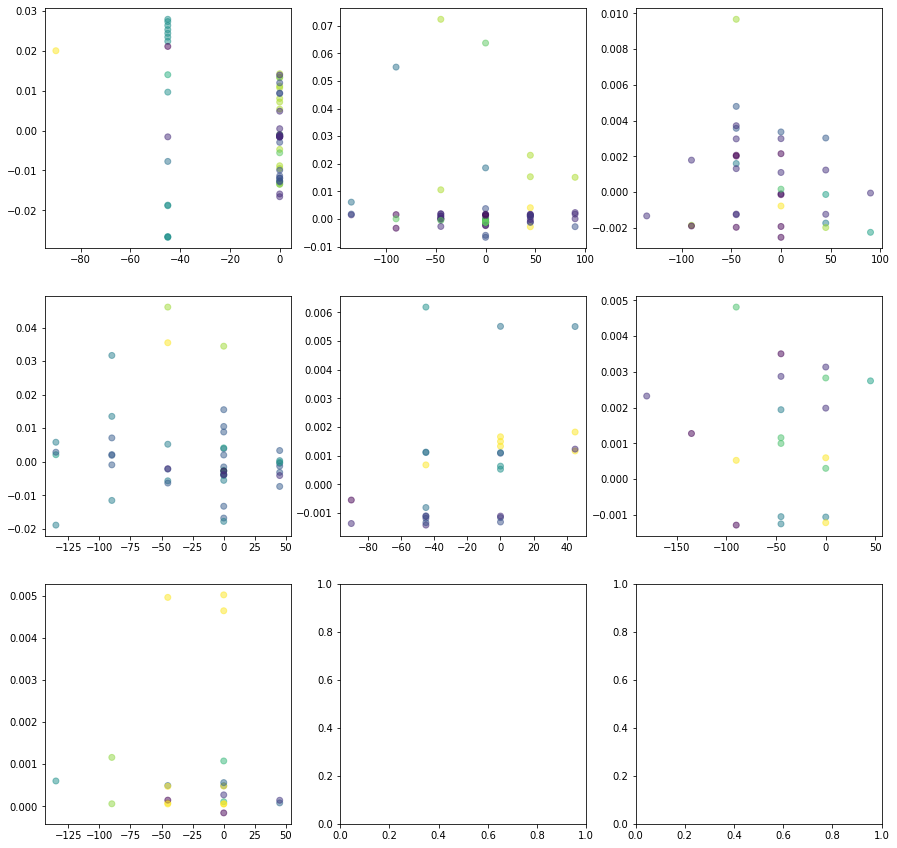

In [41]:
df_combined_shoreline_change_extremes.loc[:,'shoreline_direction_scaled'] = \
    [(x+180)/(360) for x in list(df_combined_shoreline_change_extremes.shoreline_direction)]
df_combined_shoreline_change_extremes['intersect_distance_per_year'] = \
    [x.intersect_distance/(x.end_year-x.beginning_year) for idx,x in df_combined_shoreline_change_extremes.iterrows()]

fig1 = plt.figure(figsize=(15,15))

ax1 = plt.subplot2grid((3,3),(0,0))
ax2 = plt.subplot2grid((3,3),(0,1))
ax3 = plt.subplot2grid((3,3),(0,2))
ax4 = plt.subplot2grid((3,3),(1,0))
ax5 = plt.subplot2grid((3,3),(1,1))
ax6 = plt.subplot2grid((3,3),(1,2))
ax7 = plt.subplot2grid((3,3),(2,0))
ax8 = plt.subplot2grid((3,3),(2,1))
ax9 = plt.subplot2grid((3,3),(2,2))

for ax,(key,group) in zip([ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9],
                          df_combined_shoreline_change_extremes.groupby(['atoll','islet_id'])
                         ):
    ax.scatter(group.avg_slope_change,group.intersect_distance_per_year,c=group.shoreline_direction_scaled,alpha=0.5)

## How well can a linear model explain the variance

In [42]:
from statsmodels.formula.api import ols

In [43]:
corr_dict = {}
for key,group in df_combined_shoreline_change_extremes.groupby(['atoll','islet_id']):
    print('\033[1m'+str(key)+'\033[0m')
    model = ols(
        "intersect_distance ~ proxy + shoreline_direction + NE_sheltered + ES_sheltered + SW_sheltered + WN_sheltered + avg_slope_change",
        data=group).fit()
    print(model.params)
    print(model.summary())
    print('')

('Nanumaga', 1)
Intercept              -0.004622
proxy[T.VL]             0.004652
proxy[T.WM]             0.005622
NE_sheltered[T.True]   -0.000227
ES_sheltered[T.True]   -0.015841
SW_sheltered[T.True]    0.000583
WN_sheltered[T.True]   -0.015391
shoreline_direction     0.000053
avg_slope_change       -0.000190
dtype: float64
                            OLS Regression Results                            
Dep. Variable:     intersect_distance   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     2.037
Date:                Sun, 16 Jan 2022   Prob (F-statistic):             0.0607
Time:                        18:40:04   Log-Likelihood:                 171.92
No. Observations:                  59   AIC:                            -325.8
Df Residuals:                      50   BIC:                            -307.1
Df Model:                           8   

In [44]:
corr_dict = {}
for key,group in df_combined_shoreline_change_extremes.groupby(['atoll','islet_id']):
    print('\033[1m'+str(key)+'\033[0m')
    group.intersect_distance_per_year = -group.intersect_distance_per_year
    model = ols(
        "intersect_distance_per_year ~ proxy + shoreline_direction + NE_sheltered + ES_sheltered + SW_sheltered + WN_sheltered + avg_slope_change",
        data=group).fit()
    print(model.params)
    print(model.summary())
    print('')

('Nanumaga', 1)
Intercept               0.003056
proxy[T.VL]            -0.001234
proxy[T.WM]            -0.006158
NE_sheltered[T.True]   -0.000431
ES_sheltered[T.True]    0.012735
SW_sheltered[T.True]    0.001243
WN_sheltered[T.True]    0.015315
shoreline_direction    -0.000049
avg_slope_change        0.000162
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:     intersect_distance_per_year   R-squared:                       0.260
Model:                                     OLS   Adj. R-squared:                  0.142
Method:                          Least Squares   F-statistic:                     2.199
Date:                         Sun, 16 Jan 2022   Prob (F-statistic):             0.0433
Time:                                 18:40:04   Log-Likelihood:                 175.25
No. Observations:                           59   AIC:                            -332.5
Df Residuals:                               50   BIC:   

Intercept               0.013848
proxy[T.VL]             0.006839
proxy[T.WM]             0.005909
NE_sheltered[T.True]    0.000243
ES_sheltered[T.True]   -0.016530
SW_sheltered[T.True]   -0.009869
WN_sheltered[T.True]   -0.002852
shoreline_direction    -0.000098
avg_slope_change        0.000024
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:     intersect_distance_per_year   R-squared:                       0.596
Model:                                     OLS   Adj. R-squared:                  0.506
Method:                          Least Squares   F-statistic:                     6.638
Date:                         Sun, 16 Jan 2022   Prob (F-statistic):           2.58e-05
Time:                                 18:40:05   Log-Likelihood:                 151.62
No. Observations:                           45   AIC:                            -285.2
Df Residuals:                               36   BIC:                   

## Adding Waves Features

In [45]:
# for index,row in df_combined_shoreline_change.iterrows():
#     waves_per_atoll_year_dict[(row.atoll,row.proxy,beginning_year,end_year)]

In [46]:
# waves_per_atoll_year_dict[('Nanumea', 'TOB', 1971, 1984)]

In [47]:
combined_wave_shoreline_stats_dict = {}

# Loop over each row and add wave stats
for index,row in df_combined_shoreline_change.iterrows():
    # For this atoll-proxy-year combination, get the corresponding wave stats dict
    try:
        df_wave_features = pd.concat({key:pd.DataFrame.from_dict(item,orient='index')
         for key,item in waves_per_atoll_year_dict[(row.atoll,row.proxy,row.beginning_year,row.end_year)].items()})
    except:
        print((row.atoll,row.proxy,row.beginning_year,row.end_year))
        continue
        
    # Format the wave stats so that they can be added to the row
    df_wave_features = df_wave_features.reset_index().rename(columns={'level_0':'freq1','level_1':'freq2','level_2':'dirr'})
    df_wave_features = df_wave_features.melt(['freq1','freq2','dirr']).rename(columns={'variable':'stat'})
    df_wave_features.index = \
        [(freq1,freq2,dirr,stat) for freq1,freq2,dirr,stat in zip(
            df_wave_features.freq1,df_wave_features.freq2,df_wave_features.dirr,df_wave_features.stat
        )]
    # Combine the wave stats into the row
    df_wave_features = df_wave_features['value'].T
    row = pd.concat([row,df_wave_features])
    
    # Add to a dictionary
    combined_wave_shoreline_stats_dict.update({
        index:row
    })
    
# get the wave feature list 
wave_features_list = list(df_wave_features.index)

# Combine into a single dataframe
df_combined_wave_shoreline_change = pd.DataFrame.from_dict(combined_wave_shoreline_stats_dict,orient='index')

('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanumea', 'TOB', 2014, 2016)
('Nanume

('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea', 'WM', 2012, 2014)
('Nanumea'

In [48]:
df_combined_wave_shoreline_change

,atoll,proxy,islet_id,beginning_year,end_year,x,x+n,y,y+n,m_shoreline,...,SW_sheltered,WN_sheltered,"(0.033, 0.1997, ES, mean)","(0.033, 0.1997, NE, mean)","(0.033, 0.1997, SW, mean)","(0.033, 0.1997, WN, mean)","(0.1997, 1.0, ES, mean)","(0.1997, 1.0, NE, mean)","(0.1997, 1.0, SW, mean)","(0.1997, 1.0, WN, mean)"
0,Nanumea,TOB,1,1971,1984,176.136769,176.136360,-5.701758,-5.702001,0.594855,...,False,False,39.407212,11.743294,37.197669,22.428978,3.130016,1.412008,2.678978,1.234677
1,Nanumea,TOB,1,1971,1984,176.136360,176.135914,-5.702001,-5.701554,-1.003020,...,False,True,39.407212,11.743294,37.197669,22.428978,3.130016,1.412008,2.678978,1.234677
2,Nanumea,TOB,1,1971,1984,176.135914,176.135474,-5.701554,-5.701100,-1.032140,...,False,True,39.407212,11.743294,37.197669,22.428978,3.130016,1.412008,2.678978,1.234677
3,Nanumea,TOB,1,1971,1984,176.135474,176.135048,-5.701100,-5.700633,-1.095341,...,False,True,39.407212,11.743294,37.197669,22.428978,3.130016,1.412008,2.678978,1.234677
4,Nanumea,TOB,1,1971,1984,176.135048,176.134631,-5.700633,-5.700158,-1.142439,...,False,True,39.407212,11.743294,37.197669,22.428978,3.130016,1.412008,2.678978,1.234677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29710,Nanumaga,WM,1,2019,2020,176.324724,176.324950,-6.277536,-6.278131,-2.637033,...,True,False,55.233079,12.879711,48.342665,32.782359,3.630828,0.967657,2.731853,0.611878
29711,Nanumaga,WM,1,2019,2020,176.324950,176.325149,-6.278131,-6.278734,-3.020467,...,True,True,55.233079,12.879711,48.342665,32.782359,3.630828,0.967657,2.731853,0.611878
29712,Nanumaga,WM,1,2019,2020,176.325149,176.325355,-6.278734,-6.279336,-2.925147,...,True,True,55.233079,12.879711,48.342665,32.782359,3.630828,0.967657,2.731853,0.611878
29713,Nanumaga,WM,1,2019,2020,176.325355,176.325590,-6.279336,-6.279927,-2.515648,...,True,True,55.233079,12.879711,48.342665,32.782359,3.630828,0.967657,2.731853,0.611878


## Correlations between shoreline change and previous year

In [49]:
key_vars = ['proxy','atoll','islet_id','shoreline_direction','NE_sheltered','ES_sheltered','SW_sheltered','WN_sheltered','avg_slope_change','intersect_distance']
key_vars = wave_features_list+key_vars

corr = df_combined_wave_shoreline_change[key_vars].corr()

/usr/local/lib/python3.8/dist-packages/pandas/core/common.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asarray(key)
/usr/local/lib/python3.8/dist-packages/pandas/core/common.py:208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.asarray(values, dtype=dtype)


In [50]:
corr['intersect_distance']

(0.033, 0.1997, ES, mean)    0.006517
(0.033, 0.1997, NE, mean)   -0.007087
(0.033, 0.1997, SW, mean)    0.005084
(0.033, 0.1997, WN, mean)   -0.005285
(0.1997, 1.0, ES, mean)      0.008925
(0.1997, 1.0, NE, mean)     -0.011248
(0.1997, 1.0, SW, mean)      0.005104
(0.1997, 1.0, WN, mean)     -0.010993
islet_id                    -0.001664
shoreline_direction          0.016372
NE_sheltered                -0.001686
ES_sheltered                 0.005190
SW_sheltered                -0.007847
WN_sheltered                -0.005270
avg_slope_change            -0.028385
intersect_distance           1.000000
Name: intersect_distance, dtype: float64

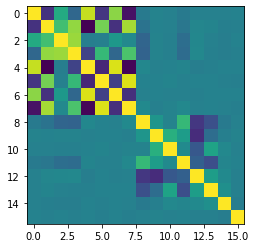

In [51]:
ax1 = plt.subplot2grid((1,1),(0,0))

ax1.imshow(corr)

# Do Beach Sheltering

In [52]:
key_vars = ['x','y','x_avg','y_avg','m_transect','c_transect','proxy','atoll','islet_id','shoreline_direction','NE_sheltered','ES_sheltered','SW_sheltered','WN_sheltered','avg_slope_change','intersect_distance']
key_vars = wave_features_list+key_vars

df_test = df_combined_wave_shoreline_change[key_vars]

In [53]:
df_test

,"(0.033, 0.1997, ES, mean)","(0.033, 0.1997, NE, mean)","(0.033, 0.1997, SW, mean)","(0.033, 0.1997, WN, mean)","(0.1997, 1.0, ES, mean)","(0.1997, 1.0, NE, mean)","(0.1997, 1.0, SW, mean)","(0.1997, 1.0, WN, mean)",x,y,...,proxy,atoll,islet_id,shoreline_direction,NE_sheltered,ES_sheltered,SW_sheltered,WN_sheltered,avg_slope_change,intersect_distance
0,39.407212,11.743294,37.197669,22.428978,3.130016,1.412008,2.678978,1.234677,176.136769,-5.701758,...,TOB,Nanumea,1,135.0,False,False,False,False,-135.0,0.000467
1,39.407212,11.743294,37.197669,22.428978,3.130016,1.412008,2.678978,1.234677,176.136360,-5.702001,...,TOB,Nanumea,1,225.0,True,False,False,True,-90.0,0.000384
2,39.407212,11.743294,37.197669,22.428978,3.130016,1.412008,2.678978,1.234677,176.135914,-5.701554,...,TOB,Nanumea,1,225.0,True,False,False,True,-0.0,0.000144
3,39.407212,11.743294,37.197669,22.428978,3.130016,1.412008,2.678978,1.234677,176.135474,-5.701100,...,TOB,Nanumea,1,225.0,True,False,False,True,-0.0,0.000099
4,39.407212,11.743294,37.197669,22.428978,3.130016,1.412008,2.678978,1.234677,176.135048,-5.700633,...,TOB,Nanumea,1,225.0,True,False,False,True,-0.0,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29710,55.233079,12.879711,48.342665,32.782359,3.630828,0.967657,2.731853,0.611878,176.324724,-6.277536,...,WM,Nanumaga,1,90.0,False,False,True,False,-0.0,-0.000093
29711,55.233079,12.879711,48.342665,32.782359,3.630828,0.967657,2.731853,0.611878,176.324950,-6.278131,...,WM,Nanumaga,1,90.0,False,False,True,True,-0.0,-0.000045
29712,55.233079,12.879711,48.342665,32.782359,3.630828,0.967657,2.731853,0.611878,176.325149,-6.278734,...,WM,Nanumaga,1,90.0,False,False,True,True,0.0,-0.000032
29713,55.233079,12.879711,48.342665,32.782359,3.630828,0.967657,2.731853,0.611878,176.325355,-6.279336,...,WM,Nanumaga,1,90.0,False,False,True,True,0.0,-0.000018


In [54]:
# For each direction, get the column names for each quadrant
NE_features = [x for x in list(df_test) if 'NE' in x]
ES_features = [x for x in list(df_test) if 'ES' in x]
SW_features = [x for x in list(df_test) if 'SW' in x]
WN_features = [x for x in list(df_test) if 'WN' in x]

NE_features.remove('NE_sheltered')
ES_features.remove('ES_sheltered')
SW_features.remove('SW_sheltered')
WN_features.remove('WN_sheltered')


In [55]:
df_NE_sheltered = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.NE_sheltered)] for i in NE_features
})

df_ES_sheltered = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.ES_sheltered)] for i in ES_features
})

df_SW_sheltered = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.SW_sheltered)] for i in SW_features
})

df_WN_sheltered = pd.DataFrame.from_dict({
    str(i):
        [wave if shelter is False else 0 for wave,shelter in zip(df_test[i],df_test.WN_sheltered)] for i in WN_features
})

In [56]:
# df_sheltered = pd.concat([df_NE_sheltered,df_ES_sheltered,df_SW_sheltered,df_WN_sheltered])
df_sheltered = df_NE_sheltered.join(df_ES_sheltered).join(df_SW_sheltered).join(df_WN_sheltered)

In [57]:
key_vars = ['x','y','x_avg','y_avg','m_transect','c_transect','proxy','atoll','islet_id','shoreline_direction','beginning_year','end_year','NE_sheltered','ES_sheltered','SW_sheltered','WN_sheltered','avg_slope_change','intersect_distance']
df_combined_shoreline_change_sheltered = df_combined_shoreline_change[key_vars].join(df_sheltered)

In [58]:
df_combined_shoreline_change_sheltered.corr()['intersect_distance']

x                               -0.007173
y                                0.004549
x_avg                           -0.007173
y_avg                            0.004559
m_transect                       0.000276
c_transect                      -0.000275
islet_id                        -0.001909
shoreline_direction              0.016204
beginning_year                  -0.004267
end_year                        -0.005051
NE_sheltered                    -0.001991
ES_sheltered                     0.004280
SW_sheltered                    -0.008147
WN_sheltered                    -0.004570
avg_slope_change                -0.029218
intersect_distance               1.000000
(0.033, 0.1997, 'NE', 'mean')    0.006021
(0.1997, 1.0, 'NE', 'mean')      0.004422
(0.033, 0.1997, 'ES', 'mean')    0.003924
(0.1997, 1.0, 'ES', 'mean')      0.004777
(0.033, 0.1997, 'SW', 'mean')    0.003345
(0.1997, 1.0, 'SW', 'mean')      0.005353
(0.033, 0.1997, 'WN', 'mean')   -0.002647
(0.1997, 1.0, 'WN', 'mean')     -0

# Shoreline Change through time

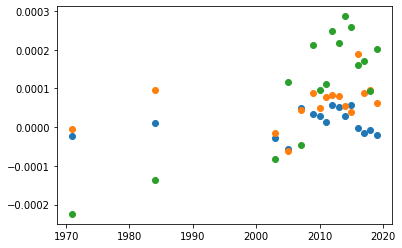

In [59]:
# See how the shoreline has changed for a single proxy through time
atoll = 'Nanumea'
# proxy = 'VL'
islet_id = 2

for proxy in ['VL','TOB','WM']:
    df_single_atoll_proxy = df_combined_shoreline_change[
        (df_combined_shoreline_change.atoll==atoll)&(df_combined_shoreline_change.proxy==proxy)&(df_combined_shoreline_change.islet_id==islet_id)
        ]

    # get the beginning year only
    df_single_atoll_proxy_year_1 = \
        df_single_atoll_proxy[
            df_single_atoll_proxy.beginning_year==np.min(df_single_atoll_proxy.beginning_year)
        ].reset_index(drop=True)

    # Pick a random row
    x_init,y_init = df_single_atoll_proxy_year_1.loc[sample(list(df_single_atoll_proxy_year_1.index),1)[0],['x','y']]

    # Pick a single point as the first point in the timeseries
    # x_init,y_init = df_single_atoll_proxy.loc[df_single_atoll_proxy.sample(1).index,['x','y']]

    # get the closest part of the shoreline in subsequent years
    intersect_dist_per_year_dict = {}
    for index,group in df_single_atoll_proxy.groupby(['beginning_year','end_year']):
        group['dist'] = ((group.x-x_init)**2+(group.y-y_init)**2)**0.5
        dist, = group.loc[(group.dist==np.min(group.dist)),'intersect_distance']

        intersect_dist_per_year_dict.update({
            index:dist
        })

    # Format dictionary into a dataframe
    df_intersect_dist_per_year = pd.DataFrame.from_dict(intersect_dist_per_year_dict,orient='index')
    df_intersect_dist_per_year['beginning_year'] = [x[0] for x in df_intersect_dist_per_year.index]
    df_intersect_dist_per_year['end_year'] = [x[1] for x in df_intersect_dist_per_year.index]
    df_intersect_dist_per_year = df_intersect_dist_per_year.reset_index(drop=True).rename(columns={0:'intersect_distance'})

    # Get the running shoreline change
    df_intersect_dist_per_year['shoreline_movement'] = df_intersect_dist_per_year.intersect_distance.cumsum()

    # Plot the results
    plt.scatter(df_intersect_dist_per_year.beginning_year,df_intersect_dist_per_year.shoreline_movement)

plt.show()

# Lag variables

In [60]:
lag_combos_dict = {}

# Loop over each combination and get the intersect_distance for the closest point in the previous year
for key,group in df_combined_shoreline_change.groupby(['atoll','islet_id','proxy']):
    
    # Get list of the beginning years
    beginning_years = np.unique(group.beginning_year)
    beginning_years = np.sort(beginning_years)

    lag_combos_per_year_dict = {}
    # Loop over each year and add the lag variables
    for year1,year2 in zip(beginning_years[:-1],beginning_years[1:]):
        df_year1 = group[group.beginning_year==year1]
        df_year2 = group[group.beginning_year==year2]

        lag_intersect_dict = {}
        for index,row in df_year2.iterrows():

            df_year1.loc[:,'closest_point'] = list(((df_year1.x-row.x)**2+(df_year1.y-row.y)**2)**0.5)
            df_year1 = df_year1.sort_values('closest_point').reset_index(drop=True)
            last_year_change = df_year1.loc[0,'intersect_distance']
            last_year_change_surroundings = np.mean(df_year1.loc[1:9,'intersect_distance'])

            row['lag_intersect_distance'] = last_year_change
            row['lag_intersect_distance_surroundings'] = last_year_change_surroundings

            lag_intersect_dict.update({
                index:row
            })

        df_combined_shoreline_lag_one_combo = pd.DataFrame.from_dict(lag_intersect_dict,orient='index')
        
        lag_combos_per_year_dict.update({
            year2:df_combined_shoreline_lag_one_combo
        })
    
    lag_combos_dict.update({
        key:pd.concat(lag_combos_per_year_dict)
    })
    
df_combined_shoreline_lag = pd.concat(lag_combos_dict).reset_index(drop=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [61]:
for index,group in df_combined_shoreline_lag.groupby(['proxy','islet_id','atoll']):
    print(
        index,
        group[['lag_intersect_distance_surroundings','lag_intersect_distance','intersect_distance']].corr().loc[
            ['lag_intersect_distance','lag_intersect_distance_surroundings'],'intersect_distance'
        ]
    )

('TOB', 1, 'Nanumaga') lag_intersect_distance                -0.014860
lag_intersect_distance_surroundings    0.011418
Name: intersect_distance, dtype: float64
('TOB', 1, 'Nanumea') lag_intersect_distance                -0.011380
lag_intersect_distance_surroundings   -0.003245
Name: intersect_distance, dtype: float64
('TOB', 2, 'Nanumea') lag_intersect_distance                -0.191087
lag_intersect_distance_surroundings   -0.167806
Name: intersect_distance, dtype: float64
('TOB', 3, 'Nanumea') lag_intersect_distance                 0.018327
lag_intersect_distance_surroundings   -0.007002
Name: intersect_distance, dtype: float64
('TOB', 4, 'Nanumea') lag_intersect_distance                -0.308650
lag_intersect_distance_surroundings   -0.323487
Name: intersect_distance, dtype: float64
('TOB', 5, 'Nanumea') lag_intersect_distance                -0.184941
lag_intersect_distance_surroundings   -0.225984
Name: intersect_distance, dtype: float64
('TOB', 6, 'Nanumea') lag_intersect_distance 

# Combine into dataframe for BN

In [62]:
list(df_combined_shoreline_change_sheltered)

['x',
 'y',
 'x_avg',
 'y_avg',
 'm_transect',
 'c_transect',
 'proxy',
 'atoll',
 'islet_id',
 'shoreline_direction',
 'beginning_year',
 'end_year',
 'NE_sheltered',
 'ES_sheltered',
 'SW_sheltered',
 'WN_sheltered',
 'avg_slope_change',
 'intersect_distance',
 "(0.033, 0.1997, 'NE', 'mean')",
 "(0.1997, 1.0, 'NE', 'mean')",
 "(0.033, 0.1997, 'ES', 'mean')",
 "(0.1997, 1.0, 'ES', 'mean')",
 "(0.033, 0.1997, 'SW', 'mean')",
 "(0.1997, 1.0, 'SW', 'mean')",
 "(0.033, 0.1997, 'WN', 'mean')",
 "(0.1997, 1.0, 'WN', 'mean')"]

In [63]:
df_wave_vars = df_combined_shoreline_change_sheltered[
    ['x','y','x_avg','y_avg','m_transect','c_transect','proxy', 'atoll', 'islet_id','beginning_year','end_year', 'shoreline_direction', 'avg_slope_change', 'intersect_distance',"(0.033, 0.1997, 'NE', 'mean')","(0.1997, 1.0, 'NE', 'mean')","(0.033, 0.1997, 'ES', 'mean')","(0.1997, 1.0, 'ES', 'mean')","(0.033, 0.1997, 'SW', 'mean')","(0.1997, 1.0, 'SW', 'mean')","(0.033, 0.1997, 'WN', 'mean')","(0.1997, 1.0, 'WN', 'mean')"]
].set_index(['x','y','x_avg','y_avg','m_transect','c_transect','proxy','islet_id','atoll','beginning_year','end_year','intersect_distance'])
# list(df_combined_shoreline_lag)

In [64]:
df_lag_vars = df_combined_shoreline_lag[
    ['x','y','x_avg','y_avg','m_transect','c_transect','atoll',
 'proxy',
 'islet_id',
 'beginning_year',
 'end_year',
 'lag_intersect_distance',
 'lag_intersect_distance_surroundings',
 'intersect_distance']
].set_index(['x','y','proxy','islet_id','atoll','beginning_year','end_year','intersect_distance'])

In [65]:
df_for_bn =\
    pd.merge(df_wave_vars,
             df_lag_vars,
             on=['x','y','x_avg','y_avg','m_transect','c_transect','proxy','islet_id','atoll','beginning_year','end_year','intersect_distance'])

In [66]:
df_for_bn.to_csv('wave_lag_vars.csv',index=True)

The lag variables have correlation for vegetation line and the water mark mostly

# Add lag variable of surrounding regions

In [67]:
lag_combos_dict = {}

# Loop over each combination and get the intersect_distance for the closest point in the previous year
for key,group in df_combined_shoreline_change.groupby(['atoll','islet_id']):
    
    # Get list of the beginning years
    beginning_years = np.unique(group.beginning_year)
    beginning_years = np.sort(beginning_years)

    # Loop over each year and add the lag variables
    for year1,year2 in zip(beginning_years[:-1],beginning_years[1:]):
        df_year1 = group[group.beginning_year==year1]
        df_year2 = group[group.beginning_year==year2]

        lag_intersect_dict = {}
        for index,row in df_year2.iterrows():

            df_year1.loc[:,'closest_point'] = list(((df_year1.x-row.x)**2+(df_year1.y-row.y)**2)**0.5)
            df_year1 = df_year1.sort_values('closest_point').reset_index(drop=True)
            last_year_change = df_year1.loc[0,'intersect_distance']
            last_year_change_surroundings = np.mean(df_year1.loc[1:9,'intersect_distance'])

            row['lag_intersect_distance'] = last_year_change
            row['lag_intersect_distance_surroundings'] = last_year_change_surroundings

            lag_intersect_dict.update({
                index:row
            })

    df_combined_shoreline_lag_one_combo = pd.DataFrame.from_dict(lag_intersect_dict,orient='index')
    
    lag_combos_dict.update({
        key:df_combined_shoreline_lag_one_combo
    })
    
df_combined_shoreline_lag = pd.concat(lag_combos_dict).reset_index(drop=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [68]:
for index,group in df_combined_shoreline_lag.groupby(['atoll','beginning_year']):
    proxies = list(np.unique(group.proxy))
    for combination in list(itertools.product(proxies,proxies)):
        if combination[0]!=combination[1]:
            group.loc[group.proxy==combination[0],'lag_proxy_{}'.format(combination[1])] = \
                list(group.loc[group.proxy==combination[1],"lag_intersect_distance"])

ValueError: Must have equal len keys and value when setting with an iterable

In [ ]:
group

In [ ]:
list(group.loc[group.proxy==combination[1],"lag_intersect_distance"]

In [ ]:
group.loc[group.proxy==combination[0],'lag_proxy_{}'.format(combination[1])]